In [38]:
import numpy as np

import dreamcoder as dc
from dreamcoder.domains.quantum_algorithms.primitives import *
from dreamcoder.domains.quantum_algorithms.tasks import *

import time
from tqdm import trange

%autoreload 2
%load_ext line_profiler

### Testing some circuits

In [39]:

n_qubit = 2
full_circuit = [n_qubit,
           [["cnot", 0, 1],
           ["swap", 0, 1],
           ["hadamard", 1]]
]

In [40]:
tensor = eye(n_qubit)
tensor_to_mat(swap(cnot(tensor,0,1),0,1))

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float16)

In [41]:
full_circuit_to_mat(full_circuit)

array([[ 0.707,  0.707,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.707,  0.707],
       [ 0.   ,  0.   ,  0.707, -0.707],
       [ 0.707, -0.707,  0.   ,  0.   ]], dtype=float16)

In [42]:
print_circuit(full_circuit)

                  
q_0: ──■───X──────
     ┌─┴─┐ │ ┌───┐
q_1: ┤ X ├─X─┤ H ├
     └───┘   └───┘


In [43]:
with QiskitTester(full_circuit) as QT:
    QT.circuit.cnot(QT.q(0),QT.q(1))
    QT.circuit.swap(QT.q(0),QT.q(1))
    QT.circuit.h(QT.q(1))
print(QT)
QT.check()

     ┌───┐   ┌───┐
q_0: ┤ X ├─X─┤ H ├
     └─┬─┘ │ └───┘
q_1: ──■───X──────
                  


Code consistent with Qiskit


In [44]:
n_qubit= 3
code = dc.program.Program.parse("(lambda (cnot (minv(mv(no_op $0)))))")
code.infer()
code.evaluate([])(n_qubit)


[[1, -1, 3], [['cnot', 1, 0]]]

In [45]:
state_circuit_to_mat(code.evaluate([])(n_qubit))

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float16)

### Testing some Tasks

In [46]:
tasks = makeTasks()

In [47]:
task = get_task_from_name("hadamard_0",tasks)
code = dc.program.Program.parse("(lambda (h (no_op $0)))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -3.8918202981106265)

In [48]:
task =get_task_from_name("cnot_01",tasks)
code = dc.program.Program.parse("(lambda (cnot (no_op $0)))")
task.logLikelihood(code), grammar.logLikelihood(code.infer(), code)

(0.0, -3.8918202981106265)

In [49]:
task = get_task_from_name("cnot_10",tasks)
code = dc.program.Program.parse("(lambda (cnot (minv(mv(no_op $0)))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -7.783640596221253)

In [50]:
task = get_task_from_name("swap_01",tasks)
code = dc.program.Program.parse("(lambda  (cnot(minv(mv_r(cnot(minv (mv (cnot (no_op $0)))))))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -15.567281192442506)

In [51]:
task = get_task_from_name("cz_01",tasks)
code = dc.program.Program.parse("(lambda (h(mv(cnot(mv_r(h (mv (no_op $0))))))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)
np.round(state_circuit_to_mat(code.evaluate([])(2)),decimals=2)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0., -1.]], dtype=float16)

In [52]:
with QiskitTester(code.evaluate([])(3)) as QT:
    QT.circuit.cz(QT.q(0),QT.q(1))
print(QT)
QT.check()
np.real(np.array(QT.result))

        
q_0: ───
        
q_1: ─■─
      │ 
q_2: ─■─
        


Code consistent with Qiskit


array([[ 1.,  0.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  1.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  1.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  1.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  1.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -0., -1.]])

In [53]:
with QiskitTester(code.evaluate([])(2)) as QT:
    QT.circuit.cz(QT.q(1),QT.q(0))
print(QT)
np.real(np.array(QT.result))

        
q_0: ─■─
      │ 
q_1: ─■─
        


array([[ 1.,  0.,  0., -0.],
       [ 0.,  1.,  0., -0.],
       [ 0.,  0.,  1., -0.],
       [ 0.,  0.,  0., -1.]])

In [54]:
task = get_task_from_name("cnot_nn_1",tasks)
code = dc.program.Program.parse("(lambda (cnot ((rep (dec(dec(size_to_int $0))) (lambda (mv $0))) (no_op $0))))")
code.evaluate([])(3)
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -14.155496613885283)

In [55]:
task = get_task_from_name("swap_0n",tasks)
code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size_to_int $0))) (lambda ((cnot(minv(mv_r(cnot(minv (mv (cnot(mv_r $0)))))))))) )  (mv_r( (rep (dec(size_to_int $0)) (lambda (mv((cnot(minv(mv_r(cnot(minv (mv (cnot $0)))))))))) ) (no_op $0) )))))")
print_circuit(code.evaluate([])(3))
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

          ┌───┐                         ┌───┐     
q_0: ──■──┤ X ├──■───────────────────■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐     ┌───┐     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├
     └───┘     └───┘┌─┴─┐└─┬─┘┌─┴─┐└───┘     └───┘
q_2: ───────────────┤ X ├──■──┤ X ├───────────────
                    └───┘     └───┘               


(0.0, -52.145060152057745)

In [56]:
## If swap was included
# task = get_task_from_name("swap_0n",tasks)
# code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size_to_int $0))) (lambda (swap(mv_r $0))) )  (mv_r( (rep (dec(size_to_int $0)) (lambda (mv(swap $0))) ) (no_op $0) )))))")
# print_circuit(code.evaluate([])(5))
# task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

In [57]:
## If swap was included
# task = get_task_from_name("swap_0n",tasks)
# code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size_to_int $0))) (lambda (swap(mv_r $0))) )  (mv_r( (rep (dec(size_to_int $0)) (lambda (mv(swap $0))) ) (no_op $0) )))))")
# print_circuit(code.evaluate([])(5))
# task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

### Profile bottom-up enumeration

In [58]:
try:
    import binutil  # required to import from dreamcoder modules
except ModuleNotFoundError:
    import bin.binutil  # alt import if called as module

from dreamcoder.domains.quantum_algorithms.main import main
from dreamcoder.dreamcoder import commandlineArguments
from dreamcoder.utilities import numberOfCPUs

arguments = commandlineArguments(
    featureExtractor=None, # it was TowerCNN
    CPUs=numberOfCPUs(),
    helmholtzRatio=0.5,
    recognitionTimeout=6,
    iterations=6,
    a=3,
    structurePenalty=1,
    pseudoCounts=10,
    topK=2,
    maximumFrontier=5,
    extras=None,
    solver="python", 
    useRecognitionModel=False,
    enumerationTimeout=6,#-g
    compressor="pypy")   #ocaml, python, pypy  


CUDA is available?: False
using cuda?: False


/Users/lsarra/opt/anaconda3/envs/dc/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/lsarra/opt/anaconda3/envs/dc/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html

In [ ]:
%lprun -f dc.domains.quantum_algorithms.primitives.tensor_contraction -f dc.domains.quantum_algorithms.tasks.QuantumTask.logLikelihood -f dc.domains.quantum_algorithms.primitives.execute_quantum_algorithm -f full_circuit_to_mat -f dc.enumeration.multicoreEnumeration main(arguments)

Running EC on 01-mar-grp-0020 @ 2022-03-25 12:32:35.820498 with 8 CPUs and parameters:
	 noConsolidation  =  False
	 iterations  =  6
	 enumerationTimeout  =  6
	 useRecognitionModel  =  False
	 topk_use_only_likelihood  =  False
	 pseudoCounts  =  10
	 aic  =  1.0
	 structurePenalty  =  1
	 arity  =  3
	 taskReranker  =  default
	 storeTaskMetrics  =  True
	 rewriteTaskMetrics  =  False
	 maximumFrontier  =  5
	 solver  =  python
	 topK  =  2
	 evaluationTimeout  =  0.01
	 cuda  =  False

Currently using this much memory: 225517568
Currently using this much memory: 225517568
Using a waking task batch of size: 19
Disabling parallelism on the Python side because we only have one job.
If you are using ocaml or bottom, there could still be parallelism.
(frontend) Launching tsize -> tcircuit (19 tasks) w/ 8 CPUs. 0.000000 <= MDL < 1.500000. Timeout 6.000000.
(frontend) Launching tsize -> tcircuit (19 tasks) w/ 8 CPUs. 1.500000 <= MDL < 3.000000. Timeout 5.966272.
(frontend) Launching tsize

Timer unit: 1e-06 s

Total time: 1.06798 s
File: /Users/lsarra/ownCloud/topics/artificial-scientific-discovery/2021_Unitary-Synthesis/ec/dreamcoder/domains/quantum_algorithms/primitives.py
Function: tensor_contraction at line 44

Line #      Hits         Time  Per Hit   % Time  Line Contents
    44                                           def tensor_contraction(A, B, indices):
    45      8907      18291.0      2.1      1.7      n_qubits = get_qubit_number(A)
    46      8907      18792.0      2.1      1.8      idx = [i + n_qubits for i in indices]
    47      8907     774326.0     86.9     72.5      out = np.tensordot(A, B, (idx, np.arange(len(indices))))
    48      8907     256571.0     28.8     24.0      return np.moveaxis(out, np.arange(-len(indices), 0, 1), idx)

Total time: 1.31214 s
File: /Users/lsarra/ownCloud/topics/artificial-scientific-discovery/2021_Unitary-Synthesis/ec/dreamcoder/domains/quantum_algorithms/primitives.py
Function: full_circuit_to_mat at line 129

Line #  

In [26]:
code = dc.program.Program.parse("(lambda ((rep (inc(inc(dec 0))) (lambda (mv $0))) (no_op $0)))")
code.evaluate([])(5)
code.infer()
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(-inf, -13.595880825949859)

## Recognition model

In [27]:
#continuationtype = tcircuit
#avoid  no _ op 

In [30]:
print(grammar)

0.000000	t0	$_
0.000000	tcircuit -> tcircuit	mv
0.000000	tcircuit -> tcircuit	mv_r
0.000000	tcircuit -> tcircuit	minv
0.000000	tsize -> tcircuit	no_op
0.000000	tcircuit -> tcircuit	h
0.000000	tcircuit -> tcircuit	cnot
0.000000	int -> (tcircuit -> tcircuit) -> tcircuit -> tcircuit	rep
0.000000	int	0
0.000000	int -> int	inc
0.000000	int -> int	dec
0.000000	tsize -> int	size_to_int


In [44]:
# Compare outputs with and without observational equivalence

# primitives = [
#     p_move_next,
#     p_no_op,
#     p_hadamard,
# ]


# grammar = dc.grammar.Grammar.uniform(primitives)

restricted_pcfg = dc.grammar.PCFG.from_grammar(grammar, request=dc.type.arrow(tsize, tcircuit))
full_pcfg = dc.grammar.PCFG.from_grammar(full_grammar, request=dc.type.arrow(tsize, tcircuit))


In [45]:
iterator = restricted_pcfg.quantized_enumeration(observational_equivalence=False)

In [47]:
for i in range(20):
    print(next(iterator))

(lambda (minv (cnot (no_op $0))))
(lambda (h (mv (no_op $0))))
(lambda (h (mv_r (no_op $0))))
(lambda (h (minv (no_op $0))))
(lambda (h (h (no_op $0))))
(lambda (h (cnot (no_op $0))))
(lambda (cnot (mv (no_op $0))))
(lambda (cnot (mv_r (no_op $0))))
(lambda (cnot (minv (no_op $0))))
(lambda (cnot (h (no_op $0))))
(lambda (cnot (cnot (no_op $0))))
(lambda (rep 0 (lambda $0) (no_op $0)))
(lambda (mv (mv (mv (no_op $0)))))
(lambda (mv (mv (mv_r (no_op $0)))))
(lambda (mv (mv (minv (no_op $0)))))
(lambda (mv (mv (h (no_op $0)))))
(lambda (mv (mv (cnot (no_op $0)))))
(lambda (mv (mv_r (mv (no_op $0)))))
(lambda (mv (mv_r (mv_r (no_op $0)))))
(lambda (mv (mv_r (minv (no_op $0)))))


In [48]:
dc.program.Program.parse("(lambda (mv (h (h (no_op $0)))))").evaluate([])(3)

[[1, 1, 3], [['hadamard', 0], ['hadamard', 0]]]

In [49]:
iterator = restricted_pcfg.quantized_enumeration(observational_equivalence=True)

In [51]:
for i in range(200):
    print(next(iterator))

(lambda (mv (minv (cnot (no_op $0)))))
(lambda (mv (h (mv (no_op $0)))))
(lambda (mv (h (cnot (no_op $0)))))
(lambda (mv (cnot (mv (no_op $0)))))
(lambda (mv (cnot (h (no_op $0)))))
(lambda (mv_r (h (mv (no_op $0)))))
(lambda (mv_r (cnot (mv (no_op $0)))))
(lambda (minv (h (mv (no_op $0)))))
(lambda (minv (h (cnot (no_op $0)))))
(lambda (minv (cnot (mv (no_op $0)))))
(lambda (minv (cnot (h (no_op $0)))))
(lambda (h (mv (mv (no_op $0)))))
(lambda (h (mv (h (no_op $0)))))
(lambda (h (mv (cnot (no_op $0)))))
(lambda (h (cnot (mv (no_op $0)))))
(lambda (h (cnot (h (no_op $0)))))
(lambda (cnot (mv (mv (no_op $0)))))
(lambda (cnot (mv (minv (no_op $0)))))
(lambda (cnot (mv (h (no_op $0)))))
(lambda (cnot (mv (cnot (no_op $0)))))
(lambda (cnot (h (mv (no_op $0)))))
(lambda (cnot (h (cnot (no_op $0)))))
(lambda (mv (mv (mv (minv (no_op $0))))))
(lambda (mv (mv (mv (h (no_op $0))))))
(lambda (mv (mv (mv (cnot (no_op $0))))))
(lambda (mv (mv (minv (h (no_op $0))))))
(lambda (mv (mv (minv (cnot (

#### Enumerating arithmetic

In [83]:
primitives = [
    # p_0,
    p_inc,
    p_dec,
]

grammar = dc.grammar.Grammar.uniform(primitives)
pcfg = dc.grammar.PCFG.from_grammar(grammar, request=dc.type.arrow(dc.type.tint, dc.type.tint))


In [86]:
iterator = pcfg.quantized_enumeration()

In [87]:
counter = 0
for i in iterator:
    counter +=1
    if counter<100:
        print(i)
    else: break

[(lambda 0)]


(lambda $0)
(lambda (inc $0))
(lambda (dec $0))
(lambda (inc (inc $0)))
(lambda (inc (dec $0)))
(lambda (dec (inc $0)))
(lambda (dec (dec $0)))
(lambda (inc (inc (inc $0))))
(lambda (inc (inc (dec $0))))
(lambda (inc (dec (inc $0))))
(lambda (inc (dec (dec $0))))
(lambda (dec (inc (inc $0))))
(lambda (dec (inc (dec $0))))
(lambda (dec (dec (inc $0))))
(lambda (dec (dec (dec $0))))
(lambda (inc (inc (inc (inc $0)))))
(lambda (inc (inc (inc (dec $0)))))
(lambda (inc (inc (dec (inc $0)))))
(lambda (inc (inc (dec (dec $0)))))
(lambda (inc (dec (inc (inc $0)))))
(lambda (inc (dec (inc (dec $0)))))
(lambda (inc (dec (dec (inc $0)))))
(lambda (inc (dec (dec (dec $0)))))
(lambda (dec (inc (inc (inc $0)))))
(lambda (dec (inc (inc (dec $0)))))
(lambda (dec (inc (dec (inc $0)))))
(lambda (dec (inc (dec (dec $0)))))
(lambda (dec (dec (inc (inc $0)))))
(lambda (dec (dec (inc (dec $0)))))
(lambda (dec (dec (dec (inc $0)))))
(lambda (dec (dec (dec (dec $0)))))
(lambda (inc (inc (inc (inc (inc $0)))))

### Program matching

In [15]:
restricted_pcfg = dc.grammar.PCFG.from_grammar(grammar, request=dc.type.arrow(tsize, tcircuit))
print(restricted_pcfg)
restricted_dictionary = dc.enumeration.enumerate_pcfg(restricted_pcfg,timeout=60, circuit_execution_function=state_circuit_to_mat)

full_pcfg = dc.grammar.PCFG.from_grammar(full_grammar, request=dc.type.arrow(tsize, tcircuit_full))
full_dictionary = dc.enumeration.enumerate_pcfg(full_pcfg,timeout=60, circuit_execution_function=full_circuit_to_mat)

start symbol: (tcircuit, (tsize,))

(tcircuit, (tsize,)) ::= mv	0x(tcircuit, (tsize,))		-1.9459101490553132
(tcircuit, (tsize,)) ::= mv_r	0x(tcircuit, (tsize,))		-1.9459101490553132
(tcircuit, (tsize,)) ::= minv	0x(tcircuit, (tsize,))		-1.9459101490553132
(tcircuit, (tsize,)) ::= no_op	0x(tsize, (tsize,))		-1.9459101490553132
(tcircuit, (tsize,)) ::= h	0x(tcircuit, (tsize,))		-1.9459101490553132
(tcircuit, (tsize,)) ::= cnot	0x(tcircuit, (tsize,))		-1.9459101490553132
(tcircuit, (tsize,)) ::= rep	0x(int, (tsize,)) 1x(tcircuit, (tcircuit, tsize)) 0x(tcircuit, (tsize,))		-1.9459101490553132

(tsize, (tsize,)) ::= $0			0.0

(int, (tsize,)) ::= 0			-1.3862943611198906
(int, (tsize,)) ::= inc	0x(int, (tsize,))		-1.3862943611198906
(int, (tsize,)) ::= dec	0x(int, (tsize,))		-1.3862943611198906
(int, (tsize,)) ::= size_to_int	0x(tsize, (tsize,))		-1.3862943611198906

(tcircuit, (tcircuit, tsize)) ::= mv	0x(tcircuit, (tcircuit, tsize))		-2.0794415416798357
(tcircuit, (tcircuit, tsize)) ::= mv_

[(lambda 0)]
Enumerated 6124 programs
[(lambda 0)]
Enumerated 6656 programs


In [16]:
matched_programs = []
for unitary in full_dictionary.keys():
    if unitary in restricted_dictionary.keys():
        try:
            full_task = full_dictionary[unitary]["task"]
            full_unitary = full_circuit_to_mat(dc.program.Program.parse(full_task).evaluate([])(4))
            
            restricted_task = restricted_dictionary[unitary]["task"]
            restricted_unitary = state_circuit_to_mat(dc.program.Program.parse(restricted_task).evaluate([])(4))

            if np.all(full_unitary==restricted_unitary):
                matched_programs.append([full_task, 
                                         restricted_task, 
                                         max(full_dictionary[unitary]["time"],restricted_dictionary[unitary]["time"])])
        except QuantumCircuitException:
            ...
eprint(f"Enumerated {len(matched_programs)} programs")
# how long it took to enumerate (when the program was found)

Enumerated 2226 programs


In [18]:
import pickle
import os
save_path = os.path.join("experimentOutputs/quantum/","matched_programs")

In [19]:
with open(save_path,"wb") as f:
    pickle.dump(matched_programs, f)

In [20]:
with open(save_path,"rb") as f:
        matched_programs = pickle.load(f)

In [23]:
dc.program.Program.parse(matched_programs[0][0]).evaluate([])(3)

[3, []]

### Feature extractor for the recognition network

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence

class BagOfWordsFeatureExtractor(nn.Module):
    def __init__(self, tasks, full_op_names): # why do we need tasks?
        super(BagOfWordsFeatureExtractor, self).__init__()
        self.recomputeTasks = False
        
        self.qubit_test_range = [3,5]
        self.qubit_num = self.qubit_test_range[1]-self.qubit_test_range[0]+1
        
        self.names = list(full_op_names.keys())
        self.len_names =len(self.names)
        
        self.outputDimensionality = self.len_names*self.qubit_num
        self.tasks=tasks
        
    # full_circuit to embedding (bag of words)
    def full_circuit_to_embedding(self, full_circuit):
        embedding = np.zeros([self.len_names], dtype=int)
        for operation in full_circuit:
            embedding[self.names.index(operation[0])]+=1
        return embedding

    def full_task_to_embedding(self,full_task):
        full_embedding = np.hstack(
            [self.full_circuit_to_embedding(full_task.target_algorithm(n_qubit)[1]) 
             for n_qubit in range(self.qubit_test_range[0],self.qubit_test_range[1]+1)]
            )
        return full_embedding
    
    def featuresOfTask(self, t):
        return dc.recognition.variable(self.full_task_to_embedding(t)).float()
    def featuresOfTasks(self, ts):
        return dc.recognition.variable([self.full_task_to_embedding(t) for t in ts]).float()
    
    def taskOfProgram(self, p, t): # why do we need this?
        return dc.task.Task("dummy task", t, [])

In [25]:
feature_extractor = BagOfWordsFeatureExtractor(None, full_op_names)
recognition_model = dc.recognition.RecognitionModel(feature_extractor, grammar)
lr=0.000001
optimizer = torch.optim.Adam(recognition_model.parameters(), lr=lr, eps=1e-3, amsgrad=True)
losses = []

In [32]:
for _ in trange(100):
    for matched_program in matched_programs:
        i = np.random.randint(0, len(matched_programs))
        task = QuantumTask("generated_task", lambda n_qubit:dc.program.Program.parse(matched_programs[i][0]).evaluate([])(n_qubit))
        embedding = recognition_model.featureExtractor.featuresOfTask(task)
        
        simple_program = dc.program.Program.parse(matched_programs[i][1])
        summary = grammar.closedLikelihoodSummary(simple_program.infer(),simple_program)

        optimizer.zero_grad()
        recognition_model.zero_grad()
        
        feature = recognition_model._MLP(embedding)
        features = feature.expand(1, feature.size(-1))
        lls = recognition_model.grammarBuilder.batchedLogLikelihoods(features, [summary])
        loss = -lls.max()
        
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())

 17%|█▋        | 17/100 [03:41<17:59, 13.01s/it]


KeyboardInterrupt: 

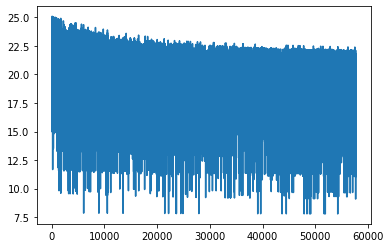

In [33]:
plt.plot(losses)

In [34]:
recognition_model.grammarBuilder.logProductions(feature)

tensor([ 0.4237,  0.0233,  0.1348, -0.3718,  0.0440,  0.7508, -1.2073,  0.8207,
         0.1788,  0.2635,  0.1615,  0.1921], grad_fn=<AddBackward0>)

In [35]:
task = get_task_from_name("cnot_10",tasks)
code = dc.program.Program.parse("(lambda (cnot (minv(mv(no_op $0)))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-7.783640596221253, tensor([-7.3444], grad_fn=<SubBackward0>))

In [36]:
task = get_task_from_name("swap_01",tasks)
code = dc.program.Program.parse("(lambda  (cnot(minv(mv_r(cnot(minv (mv (cnot (no_op $0)))))))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-15.567281192442506, tensor([-14.8894], grad_fn=<SubBackward0>))

In [37]:
task = get_task_from_name("swap_0n",tasks)
code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size_to_int $0))) (lambda ((cnot(minv(mv_r(cnot(minv (mv (cnot(mv_r $0)))))))))) )  (mv_r( (rep (dec(size_to_int $0)) (lambda (mv((cnot(minv(mv_r(cnot(minv (mv (cnot $0)))))))))) ) (no_op $0) )))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-52.145060152057745, tensor([-51.4628], grad_fn=<SubBackward0>))

In [366]:

# profile running time, enumeration speed

In [ ]:
# def train_quantum(matched_dictionary={unitaries: simple_program, complicated_list},)
# for each sample
#     embedding= feature_extractor([unitary, complicated_list]) (i.e. encoder)  #in the case of great we first need an embedding and here we get the final embedding
    
#     # apply the recognition model
#     [from frontierBiasOptimal]
#     features = self._MLP(features)
#     features = features.expand(batchSize, features.size(-1))  # TODO
#     lls = self.grammarBuilder.batchedLogLikelihoods(features, [simple_program])
        
#     # train (optimize -lls  adam)
#     lls.backward
    
# # look at the new likelihoods
#     recognitionmodel.grammarOfTask

In [ ]:
# get more enumerated tasks (10k)

# bags of words (Gates) e.g. number of occurrences for each gate
# great https://github.com/google-research/crossbeam/blob/main/crossbeam/model/great.py


In [ ]:
# observational equivalence
# https://cseweb.ucsd.edu/~npolikarpova/publications/oopsla20-probe.pdf

# let's start from arithmetic expressions

# remove no_op to enable continuation type in grammar

# continuationtype: only most recent of this type can be called